In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.cluster import pair_confusion_matrix
import warnings

warnings.filterwarnings('ignore')
random_state = 42
filename = './datasets/exam_2021_02_17_data.csv'
separator = '\t'
%matplotlib inline
np.random.seed(random_state)

# 1

In [14]:
X = pd.read_csv(filename, sep=separator)
X.columns = ['F0', 'F1', 'F2']
print(f'Dataset with {X.shape[0]} rows and {X.shape[1]} columns')
X.head()

Dataset with 1000 rows and 3 columns


,F0,F1,F2
0,d,a,a
1,c,e,c
2,j,a,c
3,f,e,j
4,c,e,d


In [12]:
np.unique(X, return_counts = True)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype=object),
 array([300, 298, 300, 300, 302, 300, 300, 300, 300, 300]))

# 2

In [15]:
transf_dtype = np.int32
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse = False, dtype = transf_dtype)

In [16]:
X_p = categorical_transformer.fit_transform(X)

# 3

In [19]:
k_range = range(2,11)

# Distortion, Silhouette Score and size deviation as measures
distortions = []
silhouette_scores = []
size_deviation = []

for i in k_range:
    
    # Iterate over our range of possible clusters
    km = KMeans(n_clusters = i, 
                init = 'k-means++', 
                n_init = 10, 
                max_iter = 300, 
                random_state = random_state)

    # Fit predict
    y_km = km.fit_predict(X_p)

    # Compute the deviation with the provided formula
    deviation = np.sqrt(np.unique(y_km, return_counts = True)[1].var())/i

    # Store the data in the arrays
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_p,y_km))
    size_deviation.append(deviation)

# 4

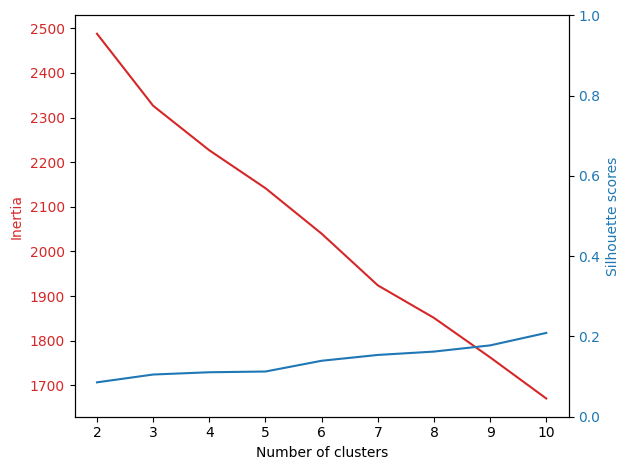

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

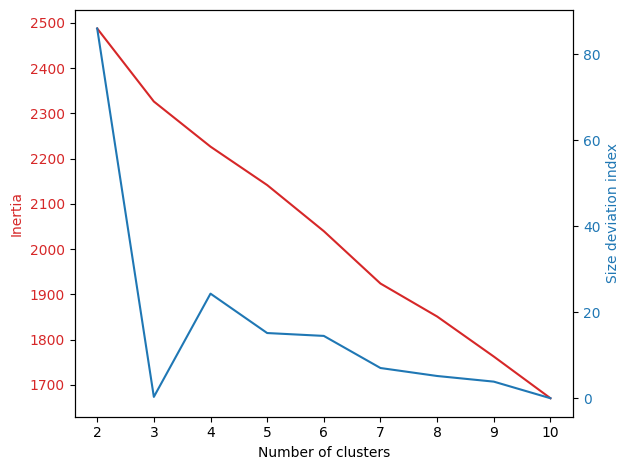

In [21]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Size deviation index', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, size_deviation, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [22]:
best_k = 3

# 5

In [23]:
param_grid = {'eps': list(np.arange(1, 30, 1)), 'min_samples': list(range(50,300,5))}
params = list(ParameterGrid(param_grid))

In [24]:
print("{:11}\t{:11}\t{:11}\t{:11}\t{:11}\t{:11}".format('        eps','min_samples',' n_clusters',' silhouette', '    unclust%', '    size deviation'))
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X_p)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X_p[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        s_deviation = np.sqrt(np.unique(y_km, return_counts = True)[1].var())/n_clusters
        print("{:11.2f}\t{:11}\t{:11}\t{:11.2f}\t{:11.2f}\t{:11.2f}"\
                  .format(db.eps, db.min_samples, n_clusters, silhouette, uncl_p, s_deviation))

        eps	min_samples	 n_clusters	 silhouette	    unclust%	    size deviation
       2.00	        280	          2	       0.06	      38.30	       0.00


# 6

In [27]:
km = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, max_iter = 300, random_state = random_state)
db = DBSCAN(eps = 2.00, min_samples = 280)

# Fit and predict
km_y = km.fit_predict(X_p)
db_y = db.fit_predict(X_p)

adjusted_rand_score(km_y, db_y)

0.06883681126821842

In [28]:
pair_confusion_matrix(km_y, db_y)


array([[440230, 226434],
       [196056, 136280]])